In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

GENERATOR

In [25]:
def generate_random_data(n, categories, weights):
    for i in range(n):
        category = random.choices(categories, weights=weights)[0]
        number   = random.randint(1, 200)
        yield {'Category': category, 'Number': number}
        
categories = ['fruit', 'légume', 'viande', 'poisson', 'intention','disk','player','population','oven','student','movie','agreement','procedure','actor', 'union', 'error', 'employee', 'security', 'region', 'user', 'cell', 'internet', 'wife', 'clothes']

weights_ref    = [0.7, 0.7, 0.7, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
weights_new    = [0., 0.1, 0.1, 0.7, 0.7, 0.7, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

random_data_ref = generate_random_data(10000, categories, weights_ref)
random_data_new = generate_random_data(10000, categories, weights_new)

df_ref = pd.DataFrame(random_data_ref)
df_new = pd.DataFrame(random_data_new)

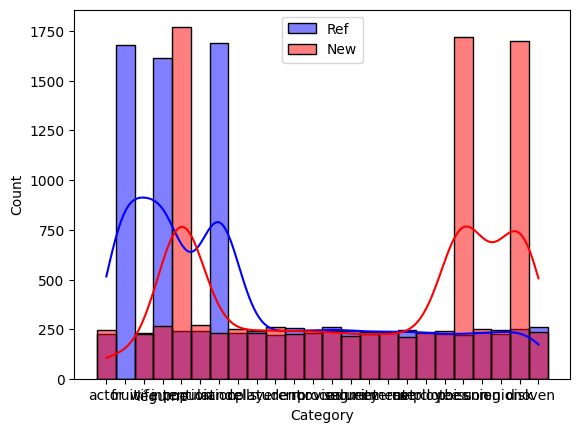

In [26]:
# Tracer l'histogramme de chaque colonne des deux dataframes
sns.histplot(df_ref['Category'], color="blue", multiple="stack", kde=True, label='Ref')
sns.histplot(df_new['Category'], color="red", multiple="stack", kde=True, label='New')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

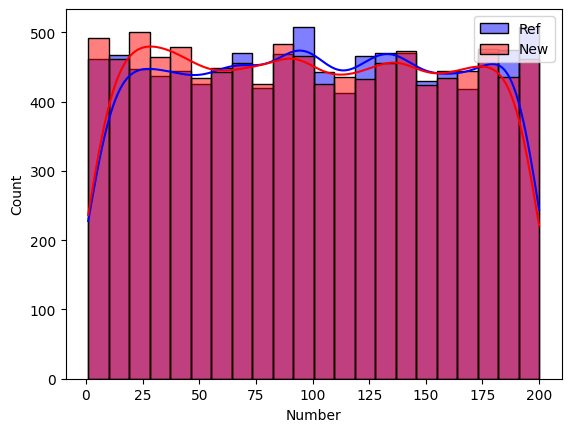

In [27]:
# Tracer l'histogramme de chaque colonne des deux dataframes
sns.histplot(df_ref['Number'], color="blue", multiple="stack", kde=True, label='Ref')
sns.histplot(df_new['Number'], color="red", multiple="stack", kde=True, label='New')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

BENCHMARK

In [28]:
def get_proba(column1, column2):
    distribution_1 = Counter(column1)
    distribution_2 = Counter(column2)

    ensemble_categories = set(list(distribution_1.keys()) + list(distribution_2.keys()))

    probabilites_1 = np.array([distribution_1.get(cat, 0) / float(sum(distribution_1.values())) for cat in ensemble_categories])
    probabilites_2 = np.array([distribution_2.get(cat, 0) / float(sum(distribution_2.values())) for cat in ensemble_categories])
    
    return [probabilites_1, probabilites_2]

In [29]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import ks_2samp, wasserstein_distance, chi2_contingency

def get_drift(probs_ref, probs_new):
    js_prob              = jensenshannon(probs_ref, probs_new)
    wd_prob              = wasserstein_distance(probs_ref, probs_new)
    _, p_chi_prob, _, _  = chi2_contingency([probs_ref,  probs_new])
    statistic, p_ks_prob = ks_2samp(probs_ref, probs_new)
    return [js_prob, p_ks_prob, wd_prob, p_chi_prob]


def check_drift(js_prob, p_ks_prob, wd_prob, p_chi_prob):
    if js_prob > 0.1:
        drift_js_prob = True
    else:
        drift_js_prob = False
    
    if p_ks_prob > 0.05:
        drift_ks_prob = False
    else:
        drift_ks_prob = True
    
    if wd_prob > 0.1:
        drift_ws_prob = True
    else:
        drift_ws_prob = False
    
    if p_chi_prob < 0.05:
        drift_chi2_prob = True
    else:
        drift_chi2_prob = False
    return [drift_js_prob, drift_ks_prob, drift_ws_prob, drift_chi2_prob]

In [30]:
benchmark = []

for column in df_new.columns:
    print(column)
    
    if(df_new[column].dtype == np.float64 or df_new[column].dtype == np.int64):
        category    = "numeric"
        
        # Faire avec les chiffres
        drif_nums   = get_drift(df_ref[column], df_new[column])
        
        # Faire avec le %
        probs       = get_proba(df_ref[column], df_new[column])
        drift_probs = get_drift(probs[0], probs[1])
        
        # Check le drift
        is_drift_num     = check_drift(drif_nums[0], drif_nums[1], drif_nums[2], drif_nums[3])
        is_drift_prob    = check_drift(drift_probs[0], drift_probs[1], drift_probs[2], drift_probs[3])

        benchmark.append({'column': column, 'type': category, 'js': round(drif_nums[0], 3), "p_ks": round(drif_nums[1], 3), "wd": round(drif_nums[2], 3), "chi2": round(drif_nums[3], 3), 'drift_js': is_drift_num[0], "drift_ks": is_drift_num[1], "drift_ws": is_drift_num[2], "drift_chi2": is_drift_num[3]})
        benchmark.append({'column': column + "_prob", 'type': category, 'js': round(drift_probs[0], 3), "p_ks": round(drift_probs[1], 3), "wd": round(drift_probs[2], 3), "chi2": round(drift_probs[3], 3), 'drift_js': is_drift_prob[0], "drift_ks": is_drift_prob[1], "drift_ws": is_drift_prob[2], "drift_chi2": is_drift_prob[3]})
        benchmark_df = pd.DataFrame(benchmark)
        
    else:
        category    = "category"
        probs       = get_proba(df_ref[column], df_new[column])
        drift_probs = get_drift(probs[0], probs[1])
        is_drift    = check_drift(drift_probs[0], drift_probs[1], drift_probs[2], drift_probs[3])
        
        benchmark.append({'column': column + "_prob", 'type': category, 'js': round(drift_probs[0], 3), "p_ks": round(drift_probs[1], 3), "wd": round(drift_probs[2], 3), "chi2": round(drift_probs[3], 3), 'drift_js': is_drift[0], "drift_ks": is_drift[1], "drift_ws": is_drift[2], "drift_chi2": is_drift[3]})
        benchmark_df = pd.DataFrame(benchmark)
        
benchmark_df

Category
Number


,column,type,js,p_ks,wd,chi2,drift_js,drift_ks,drift_ws,drift_chi2
0,Category_prob,category,0.461,0.902,0.002,1.0,True,False,False,False
1,Number,numeric,0.315,0.127,1.782,0.0,True,False,True,True
2,Number_prob,numeric,0.067,0.713,0.000,1.0,False,False,False,False


In [32]:
probs = get_proba(df_ref["Category"], df_new["Category"])
_, p_chi_prob, _, _  = chi2_contingency([df_ref["Category"], df_new["Category"]])

TypeError: '<' not supported between instances of 'str' and 'int'

In [14]:
p_chi_prob

0.8298216745950232

In [8]:
distribution_ref = Counter(df_ref["Number"])
distribution_new = Counter(df_new["Number"])
probs_ref = np.array(list(distribution_ref.values())) / len(df_ref["Number"])
probs_new = np.array(list(distribution_new.values())) / len(df_new["Number"])

In [9]:
js = jensenshannon(probs_ref, probs_new)
js

0.0015246778214480243

In [10]:
js = jensenshannon(df_ref["Number"], df_new["Number"])
js

0.10647993520148553

Archive

In [ ]:
# # il marche
# from scipy.spatial.distance import jensenshannon
# from scipy.stats import ks_2samp, wasserstein_distance, chi2_contingency

# benchmark = []

# for column in df_new.columns:
#     print(column)
    
#     if(df_new[column].dtype == np.float64 or df_new[column].dtype == np.int64):
#         category        = "numeric"
#         js              = jensenshannon(df_ref[column], df_new[column])
#         wd              = wasserstein_distance(df_ref[column], df_new[column])
#         _, p_chi, _, _  = chi2_contingency([df_ref[column], df_new[column]])
#         statistic, p_ks = ks_2samp(df_ref[column], df_new[column])
        
#     else:
#         category        = "category"
#         probs           = get_proba(df_ref[column], df_new[column])
#         js              = jensenshannon(probs[0], probs[1])
#         wd              = wasserstein_distance(probs[0], probs[1])
#         _, p_chi, _, _  = chi2_contingency([probs[0],  probs[1]])
#         statistic, p_ks = ks_2samp(probs[0], probs[1])
    
#     if js > 0.1:
#         drift_js = True
#     else:
#         drift_js = False
    
#     if p_ks > 0.05:
#         drift_ks = False
#     else:
#         drift_ks = True
    
#     if wd > 0.1:
#         drift_ws = True
#     else:
#         drift_ws = False
    
#     if p_chi < 0.05:
#         drift_chi2 = True
#     else:
#         drift_chi2 = False
    
#     benchmark.append({'column': column, 'js': round(js, 3), "p_ks": round(p_ks, 3), "wd": round(wd, 3), "chi2": round(p_chi, 3), 'drift_js': drift_js, "drift_ks": drift_ks, "drift_ws": drift_ws, "drift_chi2": drift_chi2})
#     benchmark_df = pd.DataFrame(benchmark)

In [ ]:
# # Calculate category probabilities for df_ref
# category_counts_ref = df_ref['Category'].value_counts()
# category_probabilities_ref = category_counts_ref / category_counts_ref.sum()
# category_probabilities_ref = category_probabilities_ref[categories] # re-order the probabilities by category order

# # Calculate category probabilities for df_new
# category_counts_new = df_new['Category'].value_counts()
# category_probabilities_new = category_counts_new / category_counts_new.sum()
# category_probabilities_new = category_probabilities_new[categories] # re-order the probabilities by category order

# print("Category probabilities for df_ref:")
# print(category_probabilities_ref)

# print("Category probabilities for df_new:")
# print(category_probabilities_new)

In [ ]:

# df        = pd.read_csv('adult.csv')
# size      = round(len(df)/2)
# df_train  = df.iloc[:size,:]
# df_test   = df.iloc[size:len(df)-1,:]



# df_train = pd.read_csv('reference.csv')
# df_test  = pd.read_csv('analysis.csv')
# df_test = df_test.drop(["y_pred", "y_pred_proba", "period", "timestamp", "identifier"], axis=1)